# Supervised Learning : NBA Shots Log Data (DS-SF-25 | Final Project)

This notebook is part of my final project for the General Assembly Part Time Data Science course. The project seeks to  to predict the results of field goal attempts in the 14-15 NBA regular season.

* Notebook below is a detailed exploratory analysis of the data including cleaning, parsing and transforming data for modeling
* The data source for this project: https://www.kaggle.com/dansbecker/nba-shot-logs

## Importing and Reading Data

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)

import seaborn as sns
import colorsys
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_dataset(x):
    return pd.read_csv(os.path.join('..', 'datasets', x))

df = read_dataset('shot_logs.csv')

In [3]:
df.head(2)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148


### The dataset has 21 variables. 'Shot_Result' and 'FGM' are the reponse variables. For the purpose of this project, shooter name and defender name will not be analyzed. The main purpose is to evaluate the quality of the shots; thus, who makes or defends the shots do not really matter.

In [4]:
df.columns

Index([u'GAME_ID', u'MATCHUP', u'LOCATION', u'W', u'FINAL_MARGIN',
       u'SHOT_NUMBER', u'PERIOD', u'GAME_CLOCK', u'SHOT_CLOCK', u'DRIBBLES',
       u'TOUCH_TIME', u'SHOT_DIST', u'PTS_TYPE', u'SHOT_RESULT',
       u'CLOSEST_DEFENDER', u'CLOSEST_DEFENDER_PLAYER_ID', u'CLOSE_DEF_DIST',
       u'FGM', u'PTS', u'player_name', u'player_id'],
      dtype='object')

## Datasets Dimension and NaN Drop

There are a total of 12,8069 observations. 5,567 were dropped with NaN, representing roughly 4% of the total observations.

In [5]:
df.shape

(128069, 21)

In [6]:
df.dropna(inplace = True)

In [7]:
df.shape

(122502, 21)

In [8]:
#number of observation being dropped and % as of total
print 128069-122502
print (128069-122502)/128069.

5567
0.0434687551242


## Datasets splitting

Two Pts and Three Pts

### In the dataset, 74% of the shots are 2 pts with the remainder being 3 pts.

In [9]:
df.PTS_TYPE.value_counts()

2    90852
3    31650
Name: PTS_TYPE, dtype: int64

In [10]:
two_df= df[df['PTS_TYPE']==2]

In [11]:
three_df = df[df['PTS_TYPE']==3]

In [12]:
two_df.shape

(90852, 21)

In [13]:
three_df.shape

(31650, 21)

Train and Test split

In [14]:
train_2_df = two_df.sample(frac = .6, random_state = 0)
test_2_df = two_df.drop(train_2_df.index)

In [15]:
train_3_df = three_df.sample(frac = .6, random_state = 0)
test_3_df = three_df.drop(train_3_df.index)

## Data Exploration for Two Pointers

In [16]:
train_2_df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,5.451100e+04,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.0,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000
mean,2.140045e+07,0.059181,6.487443,2.442461,12.558131,2.349471,3.080083,9.637240,2.0,159021.495166,3.450751,0.488819,0.977638,156674.939553
std,2.579646e+02,13.248577,4.719303,1.137246,5.840915,3.556042,3.077456,6.833019,0.0,78685.519864,2.341734,0.499880,0.999759,80121.880480
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-100.500000,0.000000,2.0,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-9.000000,3.000000,1.000000,8.200000,0.000000,0.900000,3.700000,2.0,200745.000000,2.000000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,2.100000,7.400000,2.0,201948.000000,3.000000,0.000000,0.000000,201936.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.700000,3.000000,4.200000,16.300000,2.0,203079.000000,4.500000,1.000000,2.000000,202702.000000
max,2.140091e+07,53.000000,37.000000,7.000000,24.000000,32.000000,24.500000,43.300000,2.0,530027.000000,52.900000,1.000000,2.000000,204060.000000


### Response Variable

In [17]:
# To make sure 'FGM=1' represents shot made.
pd.crosstab(train_2_df.FGM, train_2_df.SHOT_RESULT)

SHOT_RESULT,made,missed
FGM,,
0,0,27865
1,26646,0


In [18]:
train_2_df.FGM.value_counts()

0    27865
1    26646
Name: FGM, dtype: int64

#### The overall field goal percentage is roughly 49% in the 2-point training set. The goal is to obtain a better prediction accuracy rate than 49%.

In [19]:
train_2_df.FGM.value_counts()[1]/float(train_2_df.shape[0])

0.48881877052338057

### Predictor Variable

In [20]:
# Add some color!
color = train_2_df.FGM.map(pd.Series({0: 'red', 1: 'green'}))

Game ID

The trainingset contains 896 games.

In [21]:
GameID_count = pd.value_counts(train_2_df.GAME_ID).to_frame().reset_index()

In [22]:
GameID_count.columns = ['ID', 'count']

In [23]:
GameID_count['ID'].count()

896

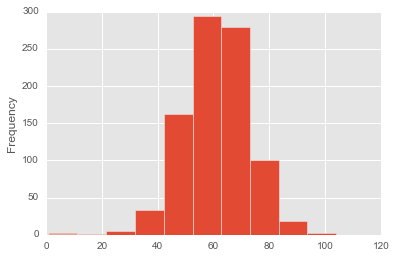

In [24]:
# it looks like some more shots are selected from a specific game than the others.
GameID_count['count'].plot(kind= 'hist')

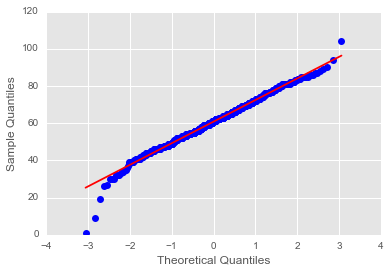

In [25]:
# The distribution follows a normal distribution.
sm.qqplot(GameID_count['count'], line = 's')
pass

In [26]:
train_2_df[['GAME_ID', 'FGM']].corr()

,GAME_ID,FGM
GAME_ID,1.000000,-0.006626
FGM,-0.006626,1.000000


MATCHUP

In [27]:
#Variable transformation
def mu_transform(mu):
    mu = mu.split(",")
    mu=mu[0]
    mu = mu.split(' ')
    mu_t=mu[0]
    return mu_t

In [28]:
train_2_df['Month']= train_2_df.MATCHUP.apply(mu_transform)

In [29]:
g = pd.value_counts(train_2_df['Month']).to_frame().reset_index()
g.columns = ['Month', 'count']

#### Shot Distribution Bar Chart by Months.

Couple observations:


* October has less shots. Expected since the season starts at the end of the month.
* March has less shots too. Might due to the splitting of the dataset.
* No shots beyong March - dataset does not include shots from the playoff

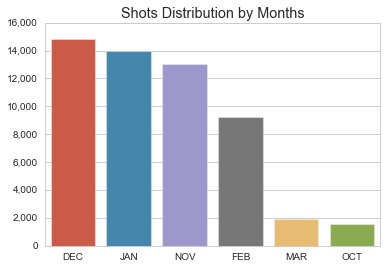

In [30]:
g = pd.value_counts(train_2_df['Month']).to_frame().reset_index()
g.columns = ['Month_', 'count']

def graph(graph_title):

    sns.set_style("whitegrid")
    ax = sns.barplot(y = 'count', x = 'Month_', data=g)
    ax.set(xlabel = '', ylabel = '', title = graph_title)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
graph('Shots Distribution by Months')

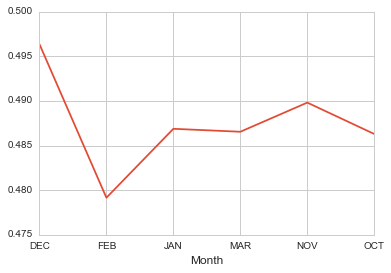

In [31]:
# Field goal percentage by months. FG% is highest in Dec while lowest in Feb.
train_2_df.groupby('Month')['FGM'].mean().plot()

Location

In [32]:
train_2_df['LOCATION'].value_counts()

A    27273
H    27238
Name: LOCATION, dtype: int64

In [33]:
#transforming variable
train_2_df['location_t'] = 0
train_2_df.at[train_2_df['LOCATION'] == 'A','location_t'] = 1
test_2_df['location_t'] = 0
test_2_df.at[test_2_df['LOCATION'] == 'A','location_t'] = 1

#### It does look like shots are more likely to go in Home game. Although the 

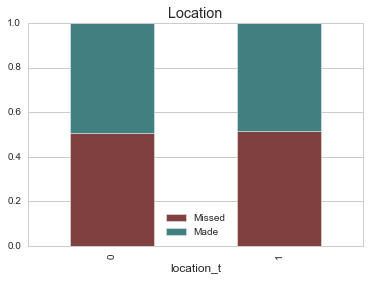

In [34]:
df_graph = pd.crosstab(train_2_df.location_t,train_2_df.FGM).apply(lambda r: r/r.sum(), axis=1)
N = len(train_2_df.location_t.value_counts().index)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
ax1 = df_graph.plot(kind="bar", stacked=True, color=RGB_tuples, title="Location")
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines,["Missed", "Made"], loc='best')

In [35]:
df_graph

FGM,0,1
location_t,,
0,0.507673,0.492327
1,0.514685,0.485315


In [36]:
train_2_df[['location_t', 'FGM']].corr()

,location_t,FGM
location_t,1.000000,-0.007014
FGM,-0.007014,1.000000


Shot Number

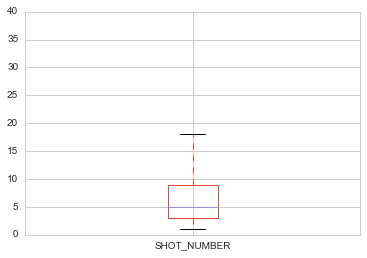

In [37]:
# It seems like majority of the players take less than 9 2-pts attempts in a game
train_2_df['SHOT_NUMBER'].plot(kind = 'box')

#### FG% by Shot Number

It looks like there is not much of FG% flux for the first 13 shots. But after 13th shots, the FG% fluctuates much widely. Part of the reasons can be attributed to a smaller population for shot number greater than 13. 

Most of the greater shot_number (>=15) field goals are taken by star players. They can easily force shots when they made consecutive field goals, making their next shots less likely to go in. Also, it is interesting to notice that beyond 26~27 shots, FG% increase dramatically. These shots are most likely taken by players with 'hot-hand' in certain games.

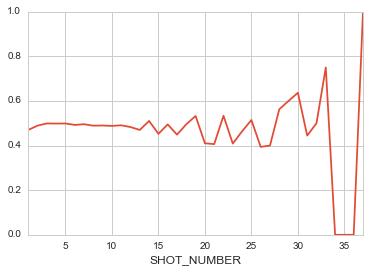

In [38]:
train_2_df.groupby('SHOT_NUMBER')['FGM'].mean().plot()

In [39]:
# number of games in which players take 15 or more shots.
train_2_df[train_2_df.SHOT_NUMBER >=15].player_name.value_counts()

lamarcus aldridge    187
russell westbrook    170
lebron james         117
carmelo anthony      116
demarcus cousins     111
                    ... 
robert covington       1
kyle oquinn            1
chris kaman            1
james johnson          1
patrick beverley       1
Name: player_name, dtype: int64

In [40]:
train_2_df[['SHOT_NUMBER', 'FGM']].corr()

,SHOT_NUMBER,FGM
SHOT_NUMBER,1.000000,-0.004529
FGM,-0.004529,1.000000


Final Margin

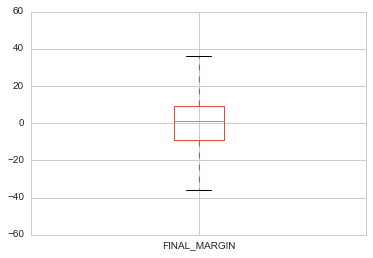

In [41]:
train_2_df['FINAL_MARGIN'].plot(kind = 'box')

####  It is expected that shots in winning game is more likely to fall that losing game. This variable is a result of the shotting result rather impacting the shotting. It will be better if we can get the margin at the time of the shot.

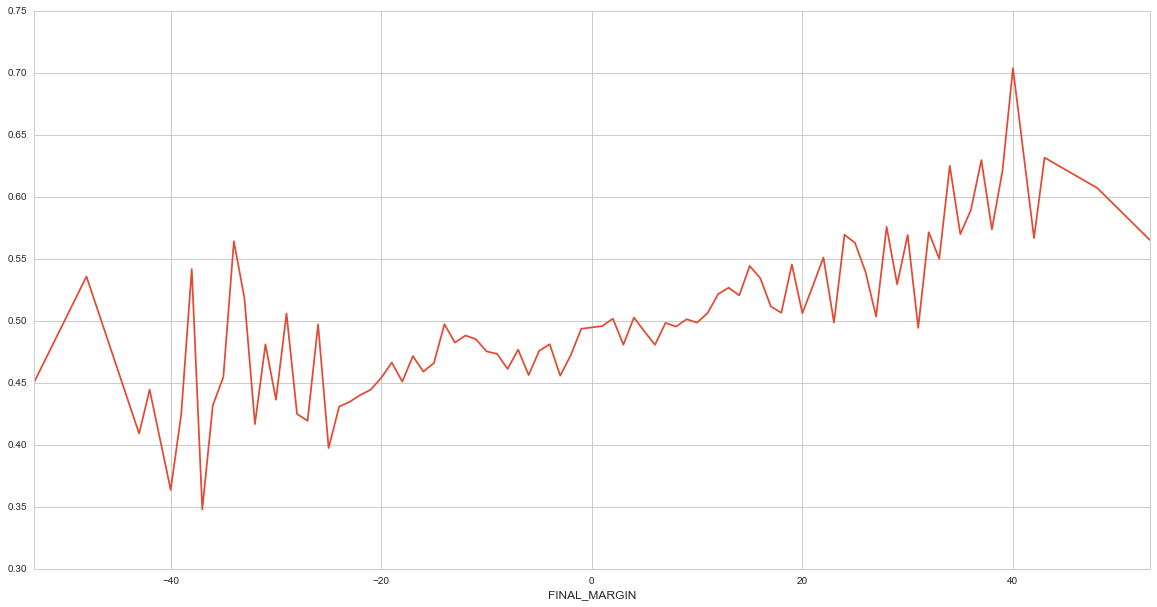

In [92]:
train_2_df.groupby('FINAL_MARGIN')['FGM'].mean().plot(figsize=(20,10))

In [94]:
train_2_df[train_2_df.FINAL_MARGIN>0]['FGM'].mean()

0.5085841613091759

In [95]:
train_2_df[train_2_df.FINAL_MARGIN<0]['FGM'].mean()

0.46887783305693753

Period and Game Clock

In [43]:
#Majority of games are not played in OT.
train_2_df['PERIOD'].value_counts()

1    14906
3    13689
2    13526
4    11933
5      377
6       61
7       19
Name: PERIOD, dtype: int64

#### It is expected that there is a slide in FG% in 4th quarter since the both teams will typically tighten up defense while there should be a graduate increase in FG% from 1st to 3rd quarter given that players are getting into rythem.

#### It is really interesting to see a big drop in FG% in the first OT period. 

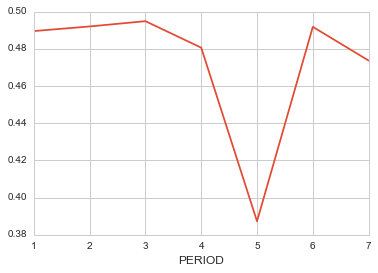

In [44]:
train_2_df.groupby('PERIOD')['FGM'].mean().plot()

In [45]:
#Game Clock variable transformation
def gc_transform(gc):
    gc = gc.split(":")
    gc0=float(gc[0])
    gc1=float(gc[1])
    gc0=gc0*60
    gc_t = gc1+gc0
    return gc_t

In [46]:
train_2_df['GAME_CLOCK_t']= train_2_df.GAME_CLOCK.apply(gc_transform)
train_3_df['GAME_CLOCK_t']= train_3_df.GAME_CLOCK.apply(gc_transform)
test_2_df['GAME_CLOCK_t']= test_2_df.GAME_CLOCK.apply(gc_transform)
test_3_df['GAME_CLOCK_t']= test_3_df.GAME_CLOCK.apply(gc_transform)

In [47]:
train_2_df['GAME_CLOCK_t'].describe()

count    54511.000000
mean       364.590266
std        201.357185
min          1.000000
25%        193.000000
50%        367.000000
75%        538.000000
max        720.000000
Name: GAME_CLOCK_t, dtype: float64

In [48]:
# 2pts
train_2_df.at[train_2_df['PERIOD'] <5,'GAME_CLOCK_t']= train_2_df['GAME_CLOCK_t']+(train_2_df.PERIOD-1)*720
train_2_df.at[train_2_df['PERIOD'] >4,'GAME_CLOCK_t']= train_2_df['GAME_CLOCK_t']+(train_2_df.PERIOD-5)*300+2880
test_2_df.at[test_2_df['PERIOD'] <5,'GAME_CLOCK_t']= test_2_df['GAME_CLOCK_t']+(test_2_df.PERIOD-1)*720
test_2_df.at[test_2_df['PERIOD'] >4,'GAME_CLOCK_t']= test_2_df['GAME_CLOCK_t']+(test_2_df.PERIOD-5)*300+2880

In [49]:
# 3pts
train_3_df.at[train_3_df['PERIOD'] <5,'GAME_CLOCK_t']= train_3_df['GAME_CLOCK_t']+(train_3_df.PERIOD-1)*720
train_3_df.at[train_3_df['PERIOD'] >4,'GAME_CLOCK_t']= train_3_df['GAME_CLOCK_t']+(train_3_df.PERIOD-5)*300+2880
test_3_df.at[test_3_df['PERIOD'] <5,'GAME_CLOCK_t']= test_3_df['GAME_CLOCK_t']+(test_3_df.PERIOD-1)*720
test_3_df.at[test_3_df['PERIOD'] >4,'GAME_CLOCK_t']= test_3_df['GAME_CLOCK_t']+(test_3_df.PERIOD-5)*300+2880

In [50]:
df_gc = pd.crosstab(train_2_df.GAME_CLOCK_t,train_2_df.FGM).apply(lambda r: r/r.sum(), axis=1)

Doesn't seem like there is much signal within a specific quarter.

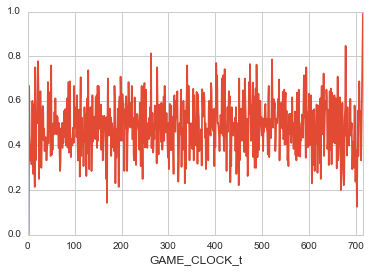

In [51]:
train_2_df[train_2_df.PERIOD==1].groupby('GAME_CLOCK_t')['FGM'].mean().plot()

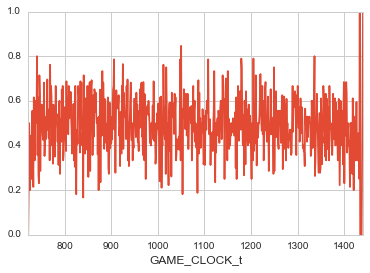

In [52]:
train_2_df[train_2_df.PERIOD==2].groupby('GAME_CLOCK_t')['FGM'].mean().plot()

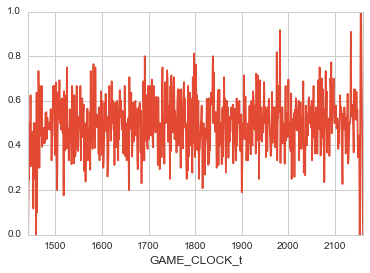

In [53]:
train_2_df[train_2_df.PERIOD==3].groupby('GAME_CLOCK_t')['FGM'].mean().plot()

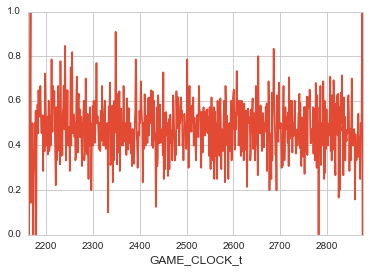

In [54]:
train_2_df[train_2_df.PERIOD==4].groupby('GAME_CLOCK_t')['FGM'].mean().plot()

In [55]:
train_2_df[['PERIOD', 'FGM']].corr()

,PERIOD,FGM
PERIOD,1.000000,-0.007739
FGM,-0.007739,1.000000


In [56]:
# take a test to see if OT impacts - do a radio for the game clock too
train_2_df[['GAME_CLOCK_t', 'FGM']].corr()

,GAME_CLOCK_t,FGM
GAME_CLOCK_t,1.000000,-0.008079
FGM,-0.008079,1.000000


Shot Clock

In [57]:
# To divide the 24s shot clock into 4 equal parts
def groupby_shotclock(x):
    if x <=6:
        return 1
    elif x<=12:
        return 2
    elif x<=18:
        return 3
    else:
        return 4
train_2_df['SHOT_CLOCK_t']= train_2_df.SHOT_CLOCK.apply(groupby_shotclock)        

Most shots are taken with 6 to 18 seconds, indicating that a typical offense takes about 8 to 18 seconds.

FG% by shot clock:
* When shots are forced to take within the last 6 seconds of the shot clock, FG% is 41%
* Shots taken from 6 to 18 seconds, FG% is 46-48%.
* Shots taken from 18 seconds to 24 seconds, FG% is 60%! (20% above shots taken within last 6 seconds). These shots actually represents rebounds, second shots attempt, tip shots, fast break off turnovers and etc. The FG% is epecially high since shots are not well defended or they are really close to the basket.

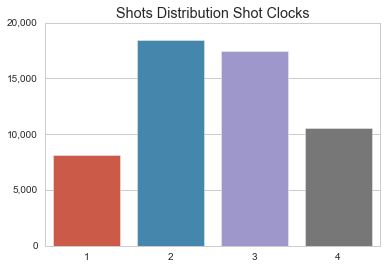

In [58]:
g = pd.value_counts(train_2_df['SHOT_CLOCK_t']).to_frame().reset_index()
g.columns = ['SHOT_CLOCK_t', 'count']

def graph(graph_title):

    sns.set_style("whitegrid")
    ax = sns.barplot(y = 'count', x = 'SHOT_CLOCK_t', data=g)
    ax.set(xlabel = '', ylabel = '', title = graph_title)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
graph('Shots Distribution Shot Clocks')

In [59]:
train_2_df.groupby('SHOT_CLOCK_t')['FGM'].mean()
g = train_2_df.groupby('SHOT_CLOCK_t')['FGM'].mean().to_frame().reset_index()
g.columns = ['SHOT_CLOCK_t', 'FG%']
g

,SHOT_CLOCK_t,FG%
0,1,0.409887
1,2,0.460750
2,3,0.488029
3,4,0.599867


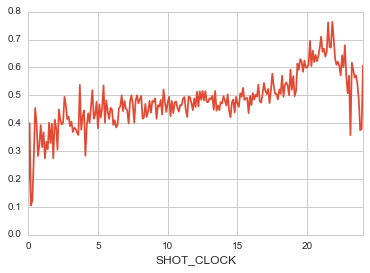

In [60]:
train_2_df.groupby('SHOT_CLOCK')['FGM'].mean().plot()

In [61]:
train_2_df[['SHOT_CLOCK', 'FGM']].corr()

,SHOT_CLOCK,FGM
SHOT_CLOCK,1.00000,0.11683
FGM,0.11683,1.00000


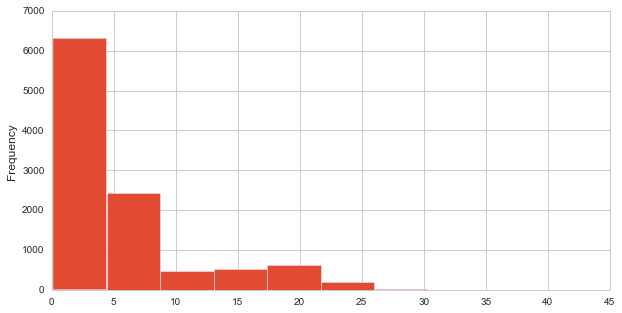

In [98]:
# Shot distance distribution for shots taken with more than 18 seconds left in the shot clock.
train_2_df[train_2_df.SHOT_CLOCK_t==4].SHOT_DIST.plot(kind='hist',figsize=(10,5))

In [63]:
# There is definitely some correlations between shot distance and shot clock.
train_2_df[['SHOT_CLOCK', 'SHOT_DIST']].corr()

,SHOT_CLOCK,SHOT_DIST
SHOT_CLOCK,1.000000,-0.247157
SHOT_DIST,-0.247157,1.000000


DRIBBLES and TOUCH_TIME

As indicated by the distribution graphs 

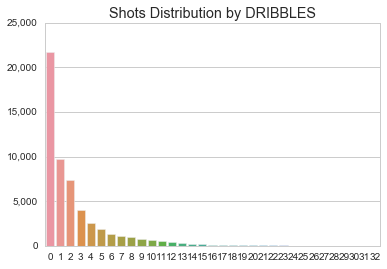

In [64]:
g = pd.value_counts(train_2_df['DRIBBLES']).to_frame().reset_index()
g.columns = ['DRIBBLES', 'count']

def graph(graph_title):

    sns.set_style("whitegrid")
    ax = sns.barplot(y = 'count', x = 'DRIBBLES', data=g)
    ax.set(xlabel = '', ylabel = '', title = graph_title)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
graph('Shots Distribution by DRIBBLES')

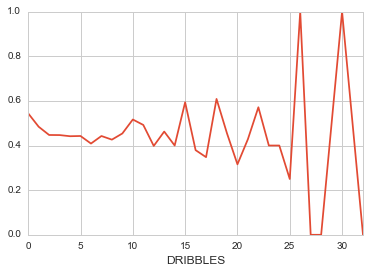

In [65]:
train_2_df[train_2_df.PERIOD==2].groupby('DRIBBLES')['FGM'].mean().plot()

In [66]:
train_2_df['Catch&Shot'] = 0
train_2_df.at[train_2_df['DRIBBLES'] == 0,'Catch&Shot'] = 1
test_2_df['Catch&Shot'] = 0
test_2_df.at[test_2_df['DRIBBLES'] == 0,'Catch&Shot'] = 1

In [67]:
train_2_df[['DRIBBLES', 'FGM']].corr()

,DRIBBLES,FGM
DRIBBLES,1.0000,-0.0654
FGM,-0.0654,1.0000


In [68]:
train_2_df[['Catch&Shot', 'FGM']].corr()

,Catch&Shot,FGM
Catch&Shot,1.000000,0.094551
FGM,0.094551,1.000000


In [69]:
train_2_df[['Catch&Shot', 'SHOT_DIST']].corr()

,Catch&Shot,SHOT_DIST
Catch&Shot,1.000000,-0.031228
SHOT_DIST,-0.031228,1.000000


In [70]:
# Strong correlation between touch time and dribbles. Basically explain the same thing.
train_2_df[['TOUCH_TIME', 'DRIBBLES']].corr()

,TOUCH_TIME,DRIBBLES
TOUCH_TIME,1.000000,0.909551
DRIBBLES,0.909551,1.000000


Shot Distance

Majority of the 2pt shots (75%) are taken within the 16 feets from the basket. From the box plot, we can see that some 2pt shots are taken well beyond the three point lines measured the arc (23.75 fts). These shots might either be misclassified as 2 pts or the distance are measured incorrectly.

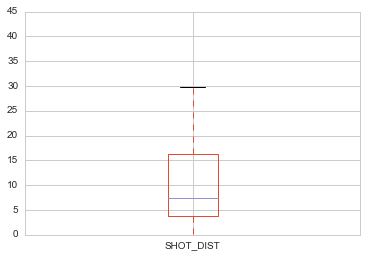

In [71]:
train_2_df['SHOT_DIST'].plot(kind = 'box')

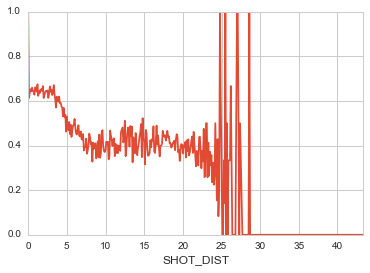

In [72]:
train_2_df.groupby('SHOT_DIST')['FGM'].mean().plot()

In [73]:
# 2pts shots that are beyond the three point line
train_2_df[train_2_df.SHOT_DIST >=23.75].shape[0]

306

In [74]:
# 2pts shots that are beyond the three point line
test_2_df[test_2_df.SHOT_DIST >=23.75].shape[0]

207

In [75]:
#dropping these misclassification or inaccurate shot distance observations
test_2_df = test_2_df.drop(test_2_df[test_2_df.SHOT_DIST >=23.75].index)

#### It looks like between 0 - 4 feets, the FG% is consistently above 60%. It starts to gradually come down as the shot distance gets further. After about 7 feets, the shot distance doesn't really impact FG% that much. Other factors seem to be behind the scene

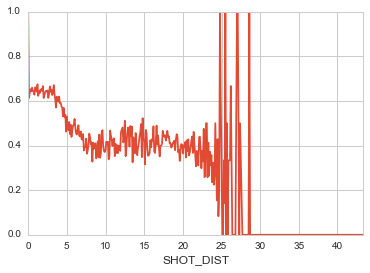

In [76]:
train_2_df.groupby('SHOT_DIST')['FGM'].mean().plot()

In [77]:
train_2_df[['SHOT_DIST', 'FGM']].corr()

,SHOT_DIST,FGM
SHOT_DIST,1.000000,-0.168766
FGM,-0.168766,1.000000


CLOSE_DEF_DIST

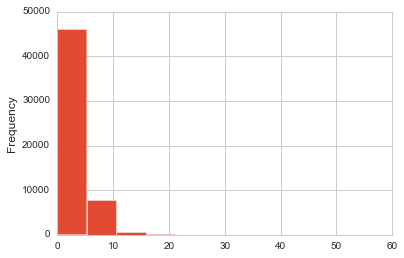

In [78]:
# Majority of the defender's distance is within 10 feets.
train_2_df['CLOSE_DEF_DIST'].plot(kind = 'hist')

FG% with defender distance within 10 feets. It looks like FG% improves with increase in defender distance.

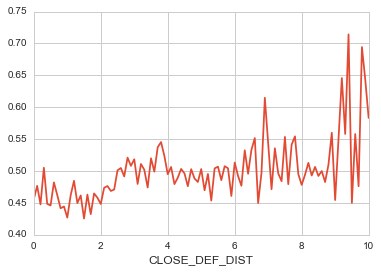

In [79]:
train_2_df[train_2_df.CLOSE_DEF_DIST <=10].groupby('CLOSE_DEF_DIST')['FGM'].mean().plot()

Not too many shots are taken with defender far away - these shots are likely to be wide open shots or shots off turnover. On average, these shots have better chance to get in.

In [80]:
train_2_df[(train_2_df.CLOSE_DEF_DIST >10)].shape[0]

845

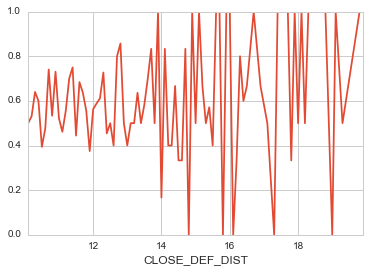

In [81]:
train_2_df[(train_2_df.CLOSE_DEF_DIST >10)&(train_2_df.CLOSE_DEF_DIST <20)].groupby('CLOSE_DEF_DIST')['FGM'].mean().plot()

In [82]:
train_2_df[['CLOSE_DEF_DIST', 'FGM']].corr()

,CLOSE_DEF_DIST,FGM
CLOSE_DEF_DIST,1.000000,0.051432
FGM,0.051432,1.000000


## Correlation Between Shot Distance and Closest Defender Distance

There seem to be correlation between shot distance and closest defender distance. It actually makes sense since defender is hard to close out shots that are further away. 

In [83]:
train_2_df[['SHOT_DIST','CLOSE_DEF_DIST']].corr()

,SHOT_DIST,CLOSE_DEF_DIST
SHOT_DIST,1.000000,0.461443
CLOSE_DEF_DIST,0.461443,1.000000


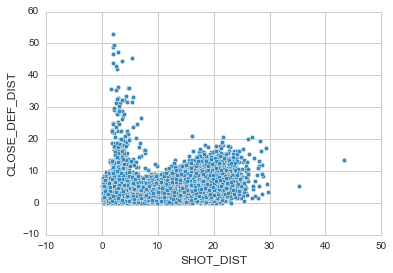

In [84]:
train_2_df.plot('SHOT_DIST','CLOSE_DEF_DIST',kind='scatter')

### Transformed Training Set Overview

In [85]:
# Describe table for significant features
train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].describe()

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST,FGM
count,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000
mean,6.487443,1402.399516,0.398250,12.558131,9.637240,3.450751,0.488819
std,4.719303,836.618140,0.489542,5.840915,6.833019,2.341734,0.499880
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,654.000000,0.000000,8.200000,3.700000,2.000000,0.000000
50%,5.000000,1369.000000,0.000000,12.300000,7.400000,3.000000,0.000000
75%,9.000000,2092.000000,1.000000,16.700000,16.300000,4.500000,1.000000
max,37.000000,3764.000000,1.000000,24.000000,43.300000,52.900000,1.000000


In [86]:
# Correlation table for significant features
train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST,FGM
SHOT_NUMBER,1.000000,0.583843,-0.081208,-0.039460,0.007986,-0.019974,-0.004529
GAME_CLOCK_t,0.583843,1.000000,-0.022117,-0.043919,-0.000534,-0.016598,-0.008079
Catch&Shot,-0.081208,-0.022117,1.000000,0.170867,-0.031228,0.154217,0.094551
SHOT_CLOCK,-0.039460,-0.043919,0.170867,1.000000,-0.247157,0.014916,0.116830
SHOT_DIST,0.007986,-0.000534,-0.031228,-0.247157,1.000000,0.461443,-0.168766
CLOSE_DEF_DIST,-0.019974,-0.016598,0.154217,0.014916,0.461443,1.000000,0.051432
FGM,-0.004529,-0.008079,0.094551,0.116830,-0.168766,0.051432,1.000000


#### Catogorizing SHOT DISTANCE and CLOSE_DEF_DIST for visualization

In [87]:
# SHOT DISTANCE transformation of visualizations
def sd_transform(sd):
    n=2
    if sd>20:
        sd_t = '20+'
    elif sd<=2:
        sd_t = 2
    elif sd<=4:
        sd_t = 4
    elif sd<=6:
        sd_t = 6
    elif sd<=8:
        sd_t = 8
    elif sd<=10:
        sd_t = 10
    elif sd<=12:
        sd_t = 12
    elif sd<=14:
        sd_t = 14
    elif sd<=16:
        sd_t = 16
    elif sd<=18:
        sd_t = 18
    else:
        sd_t = 20
    return sd_t

In [88]:
def cd_transform(sd):
    n=2
    if sd>10:
        sd_t = '10+'
    elif sd<=1:
        sd_t = 1
    elif sd<=2:
        sd_t = 2
    elif sd<=3:
        sd_t = 3
    elif sd<=4:
        sd_t = 4
    elif sd<=5:
        sd_t = 5
    elif sd<=6:
        sd_t = 6
    elif sd<=7:
        sd_t = 7
    elif sd<=8:
        sd_t = 8
    elif sd<=9:
        sd_t = 9
    else:
        sd_t = 10
    return sd_t

In [89]:
train_2_df['SHOT_DISTANCE'] = train_2_df.SHOT_DIST.apply(sd_transform)

In [90]:
train_2_df['CLOSEST_DEFENDER_DISTANE'] = train_2_df.CLOSE_DEF_DIST.apply(cd_transform)

### Output for Modeling

In [91]:
train_2_df.to_csv(os.path.join('..', 'datasets', 'train_2pts.csv'))
test_2_df.to_csv(os.path.join('..', 'datasets', 'test_2pts.csv'))